In [1]:

import numpy as np
from itertools import product
from skimage import draw, transform

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

# Introduction #

In the previous two lessons, we learned about the three operations that carry out feature extraction from an image:
1. *filter* with a **convolution** layer
2. *detect* with **ReLU** activation
3. *condense* with a **maximum pooling** layer

The convolution and pooling operations share a common feature: they are both performed over a **sliding window**. With convolution, this "window" is given by the dimensions of the kernel, the parameter `kernel_size`. With pooling, it is the pooling window, given by `pool_size`.

<figure>
<img src="https://i.imgur.com/LueNK6b.gif" width=400 alt="A 2D sliding window.">
</figure>

There are two additional parameters affecting both convolution and pooling layers -- these are the `strides` of the window and whether to use `padding` at the image edges. The `strides` parameter says how far the window should move at each step, and the `padding` parameter describes how we handle the pixels at the edges of the input.

With these two parameters, defining the two layers becomes:

In [2]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

# Stride #

The distance the window moves at each step is called the **stride**. We need to specify the stride in both dimensions of the image: one for moving left to right and one for moving top to bottom. This animation shows `strides=(2, 2)`, a movement of 2 pixels each step.

<figure>
<img src="https://i.imgur.com/Tlptsvt.gif" width=400 alt="Sliding window with a stride of (2, 2).">
</figure>

What effect does the stride have? Whenever the stride in either direction is greater than 1, the sliding window will skip over some of the pixels in the input at each step.

Because we want high-quality features to use for classification, convolutional layers will most often have `strides=(1, 1)`. Increasing the stride means that we miss out on potentially valuble information in our summary. Maximum pooling layers, however, will almost always have stride values greater than 1, like `(2, 2)` or `(3, 3)`, but not larger than the window itself.

Finally, note that when the value of the `strides` is the same number in both directions, you only need to set that number; for instance, instead of `strides=(2, 2)`, you could use `strides=2` for the parameter setting.

# Padding #

When performing the sliding window computation, there is a question as to what to do at the boundaries of the input. Staying entirely inside the input image means the window will never sit squarely over these boundary pixels like it does for every other pixel in the input. Since we aren't treating all the pixels exactly the same, could there be a problem?

What the convolution does with these boundary values is determined by its `padding` parameter. In TensorFlow, you have two choices: either `padding='same'` or `padding='valid'`. There are trade-offs with each.

When we set `padding='valid'`, the convolution window will stay entirely inside the input. The drawback is that the output shrinks (loses pixels), and shrinks more for larger kernels. This will limit the number of layers the network can contain, especially when inputs are small in size.

The alternative is to use `padding='same'`. The trick here is to **pad** the input with 0's around its borders, using just enough 0's to make the size of the output the *same* as the size of the input. This can have the effect however of diluting the influence of pixels at the borders. The animation below shows a sliding window with `'same'` padding.

<figure>
<img src="https://i.imgur.com/RvGM2xb.gif" width=400 alt="Illustration of zero (same) padding.">
</figure>

The VGG model we've been looking at uses `same` padding for all of its convolutional layers. Most modern convnets will use some combination of the two. (Another parameter to tune!)

# Example - Exploring Sliding Windows #

To better understand the effect of the sliding window parameters, it can help to observe a feature extraction on a low-resolution image so that we can see the individual pixels. Let's just look at a simple circle.

This next hidden cell will create an image and kernel for us.

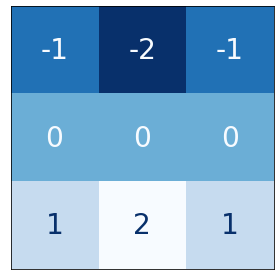

In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

The VGG architecture is fairly simple. It uses convolution with strides of 1 and maximum pooling with $2 \times 2$ windows and strides of 2. We've included a function in the `visiontools` utility script that will show us all the steps.

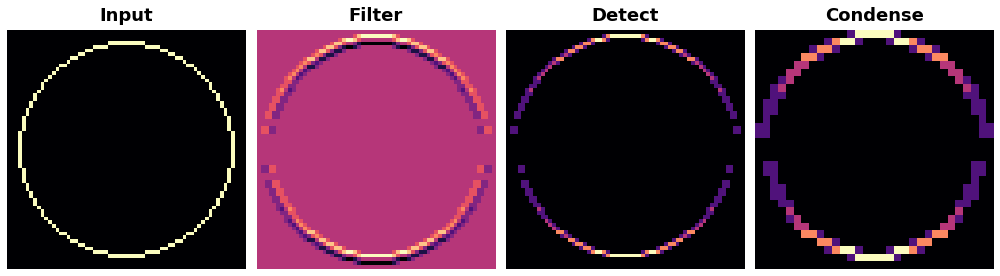

In [4]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

And that works pretty well! The kernel was designed to detect horizontal lines, and we can see that in the resulting feature map the more horizontal parts of the input end up with the greatest activation.

What would happen if we changed the strides of the convolution to 3?

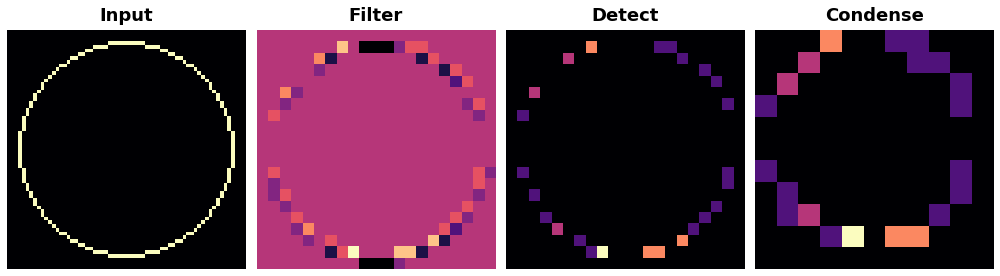

In [5]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),    
)

This seems to reduce the quality of the feature extracted. Our input circle is rather "finely detailed," being only 1 pixel wide. A convolution with strides of 3 is too coarse to produce a good feature map from it.

Sometimes, a model will use a convolution with a larger stride in it's initial layer. This will usually be coupled with a larger kernel as well. The ResNet50 model, for instance, uses $7 \times 7$ kernels with strides of 2 in its first layer. This seems to accelerate the production of large-scale features without the sacrifice of too much information from the input.

# Conclusion #

In this lesson, we looked at a characteristic computation common to both convolution and pooling: the **sliding window** and the parameters affecting its behavior in these layers. This style of windowed computation contributes much of what is characteristic of convolutional networks and is an essential part of their functioning.

# Your Turn #

Move on to the [**Exercise**](https://www.kaggle.com/kernels/fork/12400209) where you'll explore sliding windows, learn about how *stacking* convolutional layers can increase the effective window size, and also learn about how convolution can be used with *one-dimensional* data, like time series.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/196537) to chat with other Learners.*